58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.2324 - loss: 0.2591
Loss: 0.25923943519592285, Accuracy: 0.22727273404598236
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


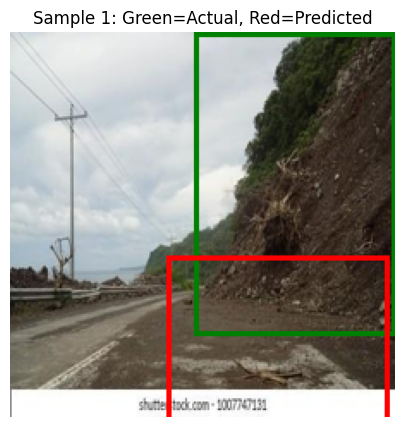

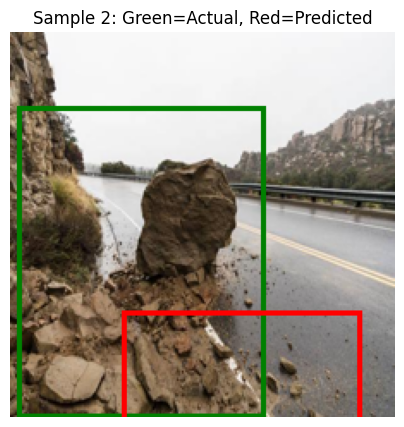

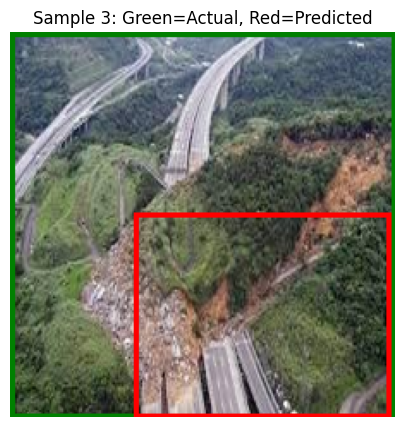

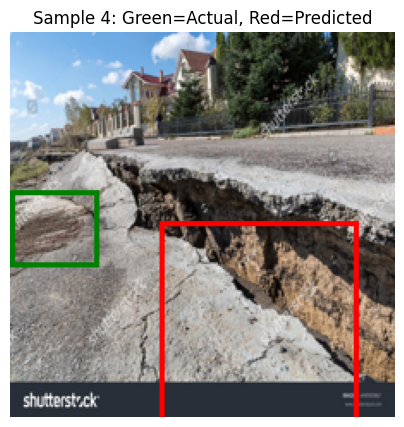

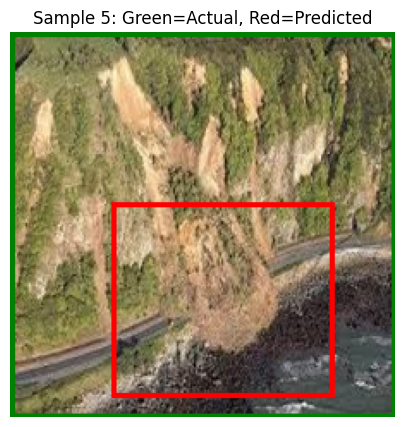

In [7]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input, Reshape
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
# Set up constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10

# Load COCO-style annotations
def load_annotations(annotation_file):
    if not os.path.exists(annotation_file):
        raise FileNotFoundError(f"Annotation file not found at: {annotation_file}")
    with open(annotation_file, 'r') as file:
        annotations = json.load(file)
    return annotations

# Preprocess images
def load_and_preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(IMG_SIZE)
    img_array = np.array(img) / 255.0  # Normalize pixel values
    return img_array

def prepare_dataset(image_folder, annotations):
    image_id_to_file = {img['id']: img['file_name'] for img in annotations['images']}
    image_id_to_bboxes = {}
    for ann in annotations['annotations']:
        image_id = ann['image_id']
        bbox = ann['bbox']  # [x, y, width, height]
        if image_id not in image_id_to_bboxes:
            image_id_to_bboxes[image_id] = []
        image_id_to_bboxes[image_id].append(bbox)

    images = []
    bboxes = []
    for image_id, file_name in image_id_to_file.items():
        image_path = os.path.join(image_folder, file_name)
        if os.path.exists(image_path):
            img_array = load_and_preprocess_image(image_path)
            images.append(img_array)

            # Normalize bounding boxes according to resized image dimensions
            img_meta = next((item for item in annotations['images'] if item['id'] == image_id), None)
            original_width = img_meta['width']
            original_height = img_meta['height']
            normalized_bboxes = [
                [x / original_width, y / original_height, w / original_width, h / original_height]
                for x, y, w, h in image_id_to_bboxes.get(image_id, [])
            ]
            # Pad with [0, 0, 0, 0] to ensure consistent shape if no bounding boxes
            # Adjust max_bboxes to the maximum number of bounding boxes per image in your dataset
            max_bboxes = 10 # Example value, adjust as needed

            padded_bboxes = normalized_bboxes + [[0, 0, 0, 0]] * (max_bboxes - len(normalized_bboxes))
            bboxes.append(padded_bboxes[:max_bboxes])

    return np.array(images, dtype=np.float32), np.array(bboxes, dtype=np.float32)

# Build VGG16 model for regression (bounding box prediction)
def build_vgg_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    # Change here: Output layer now predicts 40 values (10 boxes * 4 coordinates)
    # and then reshaped to (10, 4)
    x = Dense(40, activation='sigmoid')(x)
    outputs = Reshape((10, 4))(x)
    model = Model(inputs=base_model.input, outputs=outputs)

    for layer in base_model.layers:
        layer.trainable = False  # Freeze the pre-trained layers

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['accuracy'])
    return model

# Paths to dataset
dataset_folder = '\\Users\\sanjeev\\OneDrive\\Desktop\\landslide Detection.v1i.coco'
train_folder = os.path.join(dataset_folder, 'train')
annotation_file = os.path.join(train_folder, '_annotations.coco.json')

# Verify dataset structure
if not os.path.exists(train_folder):
    raise FileNotFoundError(f"Train folder not found at: {train_folder}")

# Load dataset and annotations
annotations = load_annotations(annotation_file)
images, bboxes = prepare_dataset(train_folder, annotations)

# Build and compile the model
model = build_vgg_model() # Call the build_vgg_model function to create the model instance


# Save the trained model
model.save('landslide_vgg_model.h5')

# Evaluate the model
eval_results = model.evaluate(images, bboxes)
print(f'Loss: {eval_results[0]}, Accuracy: {eval_results[1]}')

# Visualize Predictions
def visualize_predictions(model, images, bboxes, num_samples=5):
    predictions = model.predict(images[:num_samples])
    for i in range(num_samples):
        img = Image.fromarray((images[i] * 255).astype('uint8'))
        draw = ImageDraw.Draw(img)

        # Draw actual bounding box
        actual_bbox = bboxes[i][0]  # Only taking the first bbox
        actual_coords = [
            actual_bbox[0] * IMG_SIZE[0],
            actual_bbox[1] * IMG_SIZE[1],
            (actual_bbox[0] + actual_bbox[2]) * IMG_SIZE[0],
            (actual_bbox[1] + actual_bbox[3]) * IMG_SIZE[1],
        ]
        draw.rectangle(actual_coords, outline='green', width=3)

        # Draw predicted bounding box
        pred_bbox = predictions[i][0] # Access the first predicted bbox
        pred_coords = [
            pred_bbox[0] * IMG_SIZE[0],
            pred_bbox[1] * IMG_SIZE[1],
            (pred_bbox[0] + pred_bbox[2]) * IMG_SIZE[0],
            (pred_bbox[1] + pred_bbox[3]) * IMG_SIZE[1],
        ]
        draw.rectangle(pred_coords, outline='red', width=3)

        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(f'Sample {i+1}: Green=Actual, Red=Predicted')
        plt.axis('off')
        plt.show()

# Visualize sample predictions
visualize_predictions(model, images, bboxes)